In [1]:
import pandas as pd
import datetime

data = pd.read_csv('Online Retail.csv')

In [2]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
result = data.groupby('Country').size().reset_index(name='Count').sort_values(by='Count', ascending=False).head(20)
result

,Country,Count
36,United Kingdom,495478
14,Germany,9495
13,France,8557
10,EIRE,8196
31,Spain,2533
24,Netherlands,2371
3,Belgium,2069
33,Switzerland,2002
27,Portugal,1519
0,Australia,1259


##### the United Kingdom has a set of 495 478 examples, we should work with this one to avoid misinterpretation since we dont know much about the other countries

In [4]:
U_K = data[data['Country'] == 'United Kingdom']
U_K.CustomerID.unique().shape

(3951,)

In [5]:
sorted_counts = U_K.CustomerID.value_counts().sort_index(ascending=False)
sorted_counts

18287.0      70
18283.0     756
18282.0      13
18281.0       7
18280.0      10
           ... 
12820.0      59
12749.0     231
12748.0    4642
12747.0     103
12346.0       2
Name: CustomerID, Length: 3950, dtype: int64

In [6]:
U_K.Description.unique().shape


(4203,)

In [7]:
U_K.StockCode.unique().shape

(4065,)

there is a mismatch between the Description and the stockcode, which means each StockCode may have 1 or more Descriptions

In [8]:
U_K.groupby('StockCode')['Description'].size().reset_index(name='Count').sort_values(by='Count', ascending=False).head(20)

,StockCode,Count
3532,85123A,2215
3511,85099B,2001
1346,22423,1862
2731,47566,1634
179,20725,1460
3302,84879,1417
1145,22197,1373
1629,22720,1320
181,20727,1292
1312,22383,1260


 we should work on StockCode instead

 drop rows containing negative transaction 

In [9]:
U_K = U_K[(U_K['UnitPrice'] >= 0) & (U_K['Quantity'] >= 0)]
U_K

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,12/9/2011 12:31,1.95,15804.0,United Kingdom
541890,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,12/9/2011 12:49,2.95,13113.0,United Kingdom
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,12/9/2011 12:49,1.25,13113.0,United Kingdom
541892,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,12/9/2011 12:49,8.95,13113.0,United Kingdom


Calculate Total Amount for each row

In [10]:
U_K = U_K.copy()
U_K.loc[:, 'Amount'] = U_K['Quantity'] * U_K['UnitPrice']

Most bought articles

In [11]:
U_K.groupby('StockCode')['Quantity'].sum().reset_index()

,StockCode,Quantity
0,10002,618
1,10080,495
2,10120,183
3,10123C,5
4,10124A,16
...,...,...
3931,gift_0001_20,20
3932,gift_0001_30,37
3933,gift_0001_40,3
3934,gift_0001_50,4


Drop rows containing Nan values

In [12]:
U_K = U_K.dropna()


Create the RFM model (Recency, Frequency,Monetary value)

To create a Recency feature variable, we need to decide the reference date for analysis and we wil define the reference date as one day before the last transaction.

 customer's last transaction date

In [13]:
# Convert InvoiceDate to datetime and create a copy
U_K = U_K.assign(InvoiceDate=pd.to_datetime(U_K['InvoiceDate']))

# Calculate individual reference dates for each customer
customer_reference_dates = U_K.groupby('CustomerID')['InvoiceDate'].max() + pd.DateOffset(days=1)
customer_reference_dates = customer_reference_dates.reset_index()

customer_reference_dates

,CustomerID,InvoiceDate
0,12346.0,2011-01-19 10:01:00
1,12747.0,2011-12-08 14:34:00
2,12748.0,2011-12-10 12:20:00
3,12749.0,2011-12-07 09:56:00
4,12820.0,2011-12-07 15:12:00
...,...,...
3916,18280.0,2011-03-08 09:52:00
3917,18281.0,2011-06-13 10:53:00
3918,18282.0,2011-12-03 11:43:00
3919,18283.0,2011-12-07 12:02:00


Calculate days since last transaction for each customer

In [14]:
# Calculate the reference date
reference_date = U_K['InvoiceDate'].max() + pd.DateOffset(days=1)

# Convert the 'InvoiceDate' column in customer_reference_dates to datetime 
customer_reference_dates['InvoiceDate'] = pd.to_datetime(customer_reference_dates['InvoiceDate'])

# Calculate the days since last purchase for each customer using assign()
days_since_last_purchase = (reference_date - customer_reference_dates['InvoiceDate']).dt.days
customer_reference_dates['days_since_last_purchase'] = days_since_last_purchase


In [15]:
customer_reference_dates.sort_values(by='days_since_last_purchase', inplace=True)
customer_reference_dates.drop(columns=['InvoiceDate'], inplace=True)
customer_reference_dates.head()

,CustomerID,days_since_last_purchase
1795,15344.0,0
3373,17528.0,0
2727,16626.0,0
759,13890.0,0
2957,16933.0,0


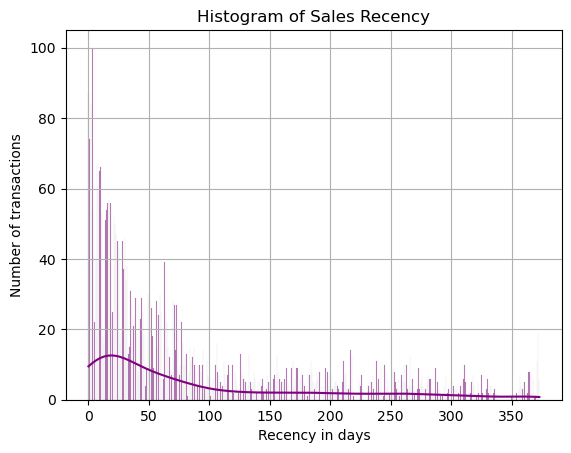

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
X = customer_reference_dates.days_since_last_purchase

# Set your preferred colors
hist_color = 'purple'

# Increase the number of bins
num_bins = 1000

# Create a histogram with more bins and custom colors for histogram and KDE line
sns.histplot(X, bins=num_bins, kde=True, color=hist_color)
plt.xlabel('Recency in days')
plt.ylabel('Number of transactions')
plt.title('Histogram of Sales Recency')
plt.grid(True)
plt.show()

The Sales recency's distribution is skewed to the left

Frequency and Monetary value

In [17]:
# Calculating customer frequency
customer_frequency = U_K['CustomerID'].value_counts().sort_index()
customer_frequency_reset = customer_frequency.reset_index()
customer_frequency_reset = customer_frequency_reset.rename(columns={'index': 'CustomerID', 'CustomerID': 'Frequency'})
customer_frequency_reset.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,103
2,12748.0,4596
3,12749.0,199
4,12820.0,59


In [18]:
customer_monetary_val = U_K.groupby('CustomerID')['Amount'].sum().reset_index()
customer_monetary_val['Amount']=customer_monetary_val['Amount']+0.001 
customer_monetary_val.head()

,CustomerID,Amount
0,12346.0,77183.601
1,12747.0,4196.011
2,12748.0,33719.731
3,12749.0,4090.881
4,12820.0,942.341


In [19]:
customer_reference_dates = customer_reference_dates.rename(columns={'days_since_last_purchase': 'Recency'})
customer_reference_dates=customer_reference_dates.merge(customer_frequency_reset, how='outer')
customer_reference_dates=customer_reference_dates.merge(customer_monetary_val, how='outer')
customer_history = customer_reference_dates

In [20]:
customer_history

,CustomerID,Recency,Frequency,Amount
0,15344.0,0,26,563.941
1,17528.0,0,253,3628.501
2,16626.0,0,179,4413.101
3,13890.0,0,110,1883.811
4,16933.0,0,44,563.231
...,...,...,...,...
3916,17968.0,373,85,277.351
3917,18074.0,373,13,489.601
3918,17908.0,373,58,243.281
3919,13747.0,373,1,79.601


In [21]:
customer_history = customer_history[(customer_history['Recency'] >= 0) & (customer_history['Amount'] >= 0) & (customer_history['Frequency'] >= 0)]
customer_history['Recency']=customer_history['Recency']+0.001 


In [22]:
from sklearn import preprocessing
import math

#Apply log to RFA values
customer_history['Recency_log'] = customer_history['Recency'].apply(math.log)
customer_history['Frequency_log'] = customer_history['Frequency'].apply(math.log)
customer_history['Amount_log'] = customer_history['Amount'].apply(math.log)

# creat list of RFA names, to use later for feature extraction
feature_vector=['Recency_log','Frequency_log','Amount_log']

#extract values from customer_history, obtaining a 3921*3 array
X=customer_history[feature_vector].values

#Scaling features
scaler=preprocessing.StandardScaler()
X_scaled=scaler.fit_transform(X)

Visualizing Recency and Frequency vs Monetary Value (Scaled)

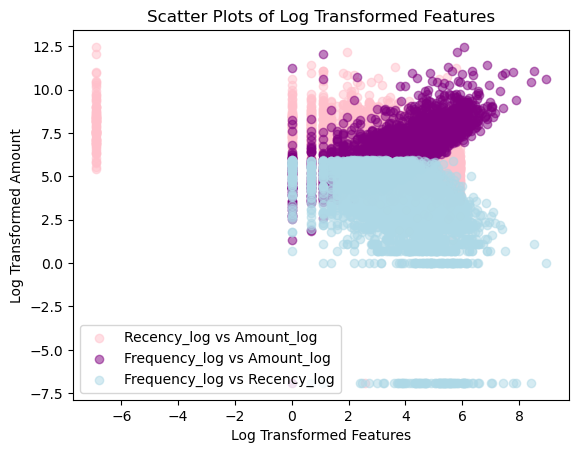

In [23]:
import matplotlib.pyplot as plt

# Create scatter plots
plt.scatter(customer_history['Recency_log'], customer_history['Amount_log'], alpha=0.5, color='pink', label='Recency_log vs Amount_log')
plt.scatter(customer_history['Frequency_log'], customer_history['Amount_log'], alpha=0.5, color='purple', label='Frequency_log vs Amount_log')
plt.scatter(customer_history['Frequency_log'], customer_history['Recency_log'], alpha=0.5, color='lightblue', label='Frequency_log vs Recency_log')

# Set labels for x and y axes
plt.xlabel('Log Transformed Features')
plt.ylabel('Log Transformed Amount')

# Set title
plt.title('Scatter Plots of Log Transformed Features')

# Create a legend
plt.legend()

# Show the plot
plt.show()


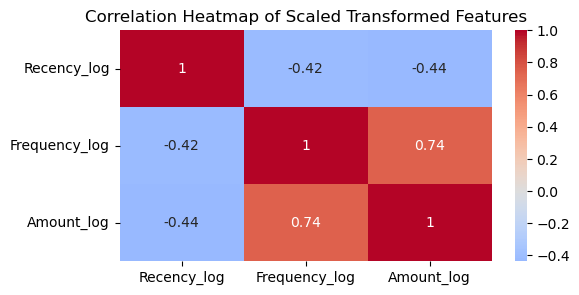

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_vector)

# Calculate the correlation matrix
correlation_matrix = X_scaled_df.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(6, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Scaled Transformed Features')
plt.show()


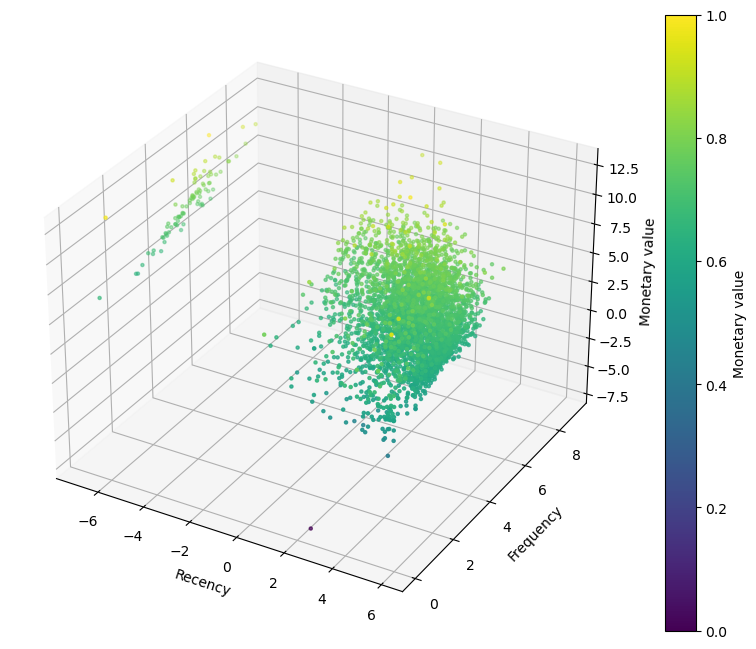

In [25]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
xs = customer_history.Recency_log
ys = customer_history.Frequency_log
zs = customer_history.Amount_log

# Create a colormap based on the zs values
cmap = plt.get_cmap('viridis')

# Normalize the zs values for colormap
norm = plt.Normalize(zs.min(), zs.max())
colors = cmap(norm(zs))

# Create the scatter plot with specified colors
scatter = ax.scatter(xs, ys, zs, color=colors, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary value')

# Add a color bar to the plot
colorbar = plt.colorbar(scatter)
colorbar.set_label('Monetary value')

plt.show()

The 3D plot reveals a clear trend: customers who buy more frequently and more recently tend to spend more. This is evident from the rising trend in monetary value as we move along the frequency and recency axes. In essence, higher values along these axes correlate with higher spending.

In [26]:
customer_history.to_csv('customer_history.csv', index=False)